In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm_notebook

In [2]:
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
from plotly import graph_objs as go
from plotly import tools as tls

In [3]:
index = ['sto_vol_all',
         'sto_vol_twt',
         'sto_rea_all',
         'sto_rea_twt',
         'sto_si1_all', 
         'sto_si2_all', 
         'sto_si3_all', 
         'sto_si1_twt', 
         'sto_si2_twt', 
         'sto_si3_twt',
         'stw_vol_dcl',
         'stw_vol_brt',
         'stw_si1_dcl',
         'stw_si2_dcl',
         'stw_si3_dcl', 
         'stw_si1_brt', 
         'stw_si2_brt',
         'stw_si3_brt']

In [4]:
sc = pd.DataFrame(np.zeros((18, 4)), index=index, columns=['btc', 'eth', 'aapl', 'spx'])
for i, file in tqdm_notebook(enumerate(os.listdir('data/pred/'))):
    _, source, type1, type2, symbol = file.split('.')[0].split('_')
    
    if type2 == 'fbp' or type1 == 'fbp':
        continue
    
    new = source + '_' + type1 + '_' + type2
    if type2.startswith('si'):
        new = source + '_' + type2 + '_' + type1
    
    data = pd.read_csv('data/pred/' + file, index_col=0, parse_dates=True)[1:]
    prices = pd.read_csv('data/prices_open/prices_open_' + symbol + '.csv', index_col=0, parse_dates=True)[1:]
    
    th = 0.6
    dec_history = []
    capital = 100000
    assets = 0
    curr = pd.Series()
    for s, p in zip(data.pred[:-1], prices.price_open):
        decision = 0
        if s > curr.quantile(th):
            decision = 1
        if s < curr.quantile(1 - th):
            decision = -1

        if decision == 1 and capital > 0:
            assets = capital / p
            capital = 0
        elif decision == -1 and assets > 0:
            capital = assets * p
            assets = 0

        dec_history.append([s, decision, capital, p, assets, (max(capital, assets * p) - 100000) / 100000, (p - prices.price_open[0]) / prices.price_open[0]])
        curr = curr.append(pd.Series(s))
    final = max(capital, assets * prices.price_open[-1])
    final = (final - 100000) / 100000
    sc.loc[new, symbol] = final

In [5]:
a = (sc * 100).round(2)
a

,btc,eth,aapl,spx
sto_vol_all,48.39,20.80,2.87,8.08
sto_vol_twt,101.21,-19.55,12.34,10.88
sto_rea_all,179.23,-13.45,43.30,21.58
sto_rea_twt,110.47,97.27,26.29,12.58
sto_si1_all,22.37,-51.91,6.18,3.41
sto_si2_all,22.37,-52.48,0.98,3.55
sto_si3_all,22.37,-52.48,0.98,3.55
sto_si1_twt,-34.01,-53.56,8.36,0.51
sto_si2_twt,-34.01,-54.24,5.77,3.11
sto_si3_twt,-34.01,-53.56,8.87,3.20


In [6]:
a['avg'] = a.apply(np.mean, axis=1)

In [7]:
a

,btc,eth,aapl,spx,avg
sto_vol_all,48.39,20.80,2.87,8.08,20.0350
sto_vol_twt,101.21,-19.55,12.34,10.88,26.2200
sto_rea_all,179.23,-13.45,43.30,21.58,57.6650
sto_rea_twt,110.47,97.27,26.29,12.58,61.6525
sto_si1_all,22.37,-51.91,6.18,3.41,-4.9875
sto_si2_all,22.37,-52.48,0.98,3.55,-6.3950
sto_si3_all,22.37,-52.48,0.98,3.55,-6.3950
sto_si1_twt,-34.01,-53.56,8.36,0.51,-19.6750
sto_si2_twt,-34.01,-54.24,5.77,3.11,-19.8425
sto_si3_twt,-34.01,-53.56,8.87,3.20,-18.8750


In [10]:
b = a['avg'].sort_values(ascending=False)

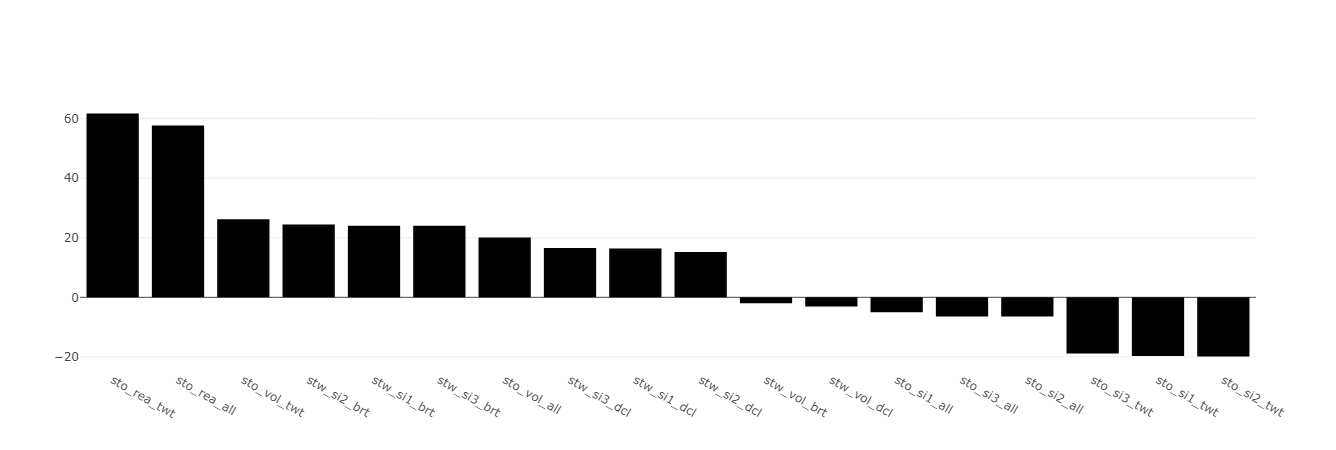

In [11]:
fig = go.Figure()
fig.add_trace(go.Bar(x=b.index, y=b, marker_color='rgb(0,0,0)', orientation='v'))
iplot(fig)